In [1]:
import numpy as np
from matplotlib import pyplot as plt
from data_prep import *

In [2]:
def plot_keypoints(data):
    idx = np.random.randint(0, len(data.samples), 1)[-1]
    plt.imshow(data[idx][0][0], cmap='gray')
    coords = data[idx][1].reshape(len(data[idx][1])//2, 2)
    plt.scatter(coords[:, 0], coords[:, 1], color='red', s=5)
    plt.show()

In [3]:
train = KeyPointGen(train=True)
test = KeyPointGen(train=False)

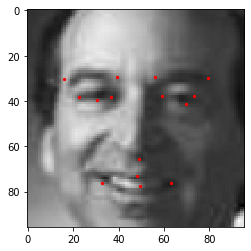

In [4]:
plot_keypoints(train)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [7]:
len(train[0][1])
# we need to model our CNN based on these number of output features
# our output shape should be 1 x 1 x N ( N is the number of out features )

30

In [8]:
class KeyPoint(nn.Module):
    def __init__(self, in_channels=1):
        super(KeyPoint, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 5)
        # 92x92x32
        # 46x46x32
        self.conv2 = nn.Conv2d(32, 64, 3)
        # 44x44x64
        # 22x22x64
        self.conv3 = nn.Conv2d(64, 64, 3)
        # 20x20x64
        self.conv4 = nn.Conv2d(64, 128, 7)
        # 14x14x128
        self.conv5 = nn.Conv2d(128, 32, 5)
        # 10x10x32
        # 5x5x32
        self.conv6 = nn.Conv2d(32, 30, 5)
        # 1x1x30
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv5(x)))
        x = self.conv6(x)
        
        return x       

In [9]:
keypoint = KeyPoint(in_channels=1)
keypoint

KeyPoint(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv5): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 30, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [10]:
EPOCHS = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(keypoint.parameters(), lr=0.003)

In [11]:
# testing the output of the Model
inp = next(iter(train_loader))
inp[0].shape

torch.Size([64, 1, 96, 96])

In [12]:
# testing for correctness of dimensions
out = keypoint(inp[0].float())
y = inp[1]
criterion(out.view(-1, out.size(1)), y)

tensor(2613.0203, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [11]:
from tqdm import tqdm

def train_model(model, optimizer, criterion, train_loader, EPOCHS):
    model.train()
    loss_history = []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        running_loss = 0.0
        for i,dat in enumerate(train_loader):
            
            model.zero_grad()
            x, y = dat
            out = model(x.float())
            loss = criterion(out.view(-1, out.size(1)).float(), y.float())
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if i % 50 == 49:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Running Loss {running_loss/i+1}')
                loss_history.append(running_loss/(i+1))
                running_loss = 0.0
        print(f'Epoch Loss {loss.item()}')
    print('Training Done')
    return model, optimizer, criterion, loss_history

In [170]:
keypoint, optimizer, criterion, loss_history = train_model(keypoint, optimizer, criterion, train_loader, EPOCHS)

Epoch 1/10
Epoch 1, Batch 50, Running Loss 34.50082933659456
Epoch 1, Batch 100, Running Loss 4.945011832497336
Epoch Loss 4.943003177642822
Epoch 2/10
Epoch 2, Batch 50, Running Loss 9.218493159936399
Epoch 2, Batch 100, Running Loss 4.6573191026244505
Epoch Loss 5.616365432739258
Epoch 3/10
Epoch 3, Batch 50, Running Loss 9.229681900569371
Epoch 3, Batch 100, Running Loss 4.873063626915517
Epoch Loss 11.462591171264648
Epoch 4/10
Epoch 4, Batch 50, Running Loss 9.322882360341598
Epoch 4, Batch 100, Running Loss 4.90131918589274
Epoch Loss 12.729804039001465
Epoch 5/10
Epoch 5, Batch 50, Running Loss 9.216290639371287
Epoch 5, Batch 100, Running Loss 5.0235570079148415
Epoch Loss 3.99306058883667
Epoch 6/10
Epoch 6, Batch 50, Running Loss 9.361150868084966
Epoch 6, Batch 100, Running Loss 4.873956911491625
Epoch Loss 4.3627028465271
Epoch 7/10
Epoch 7, Batch 50, Running Loss 8.605574802476532
Epoch 7, Batch 100, Running Loss 5.1403051482306585
Epoch Loss 7.410686492919922
Epoch 8/10
E

In [171]:
# testing the model
keypoint.eval()
outputs = []

with torch.no_grad():
    for dat in test_loader:
        x, y = dat
        out = keypoint(x.float())
        outputs.append([x.view(-1, 96, 96), out.view(-1, 30)])

In [33]:
def plot_predictions(data):
    idx = np.random.randint(0, 64, 1)[-1] # since batch size is 64
    x = data[0][idx].data.numpy()
    coords = data[1][idx].data.numpy()
    
    plt.imshow(x, cmap='gray')
    coords = coords.reshape(15, 2)
    plt.scatter(coords[:, 0], coords[:, 1], color='r', s=10)
    plt.show()

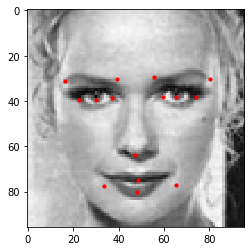

In [187]:
plot_predictions(outputs[3])

In [21]:
# more traditional model
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()
        
        # 96x96
        self.conv1 = nn.Conv2d(in_channels, 32, 5)
        # 92x92
        # 46x46
        self.conv2 = nn.Conv2d(32, 64, 3)
        # 44x44
        # 22x22
        self.conv3 = nn.Conv2d(64, 128, 3)
        # 20x20
        # 10x10
        self.fc1 = nn.Linear(10*10*128, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, 30)
        
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [22]:
net = Net(1)
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=30, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [29]:
test_input = next(iter(train_loader))
net(test_input[0].float())

tensor([[-0.0133, -0.0105,  0.0329,  ...,  0.0382, -0.0292, -0.0413],
        [-0.0157, -0.0114,  0.0292,  ...,  0.0400, -0.0322, -0.0412],
        [-0.0161, -0.0102,  0.0310,  ...,  0.0387, -0.0325, -0.0420],
        ...,
        [-0.0163, -0.0100,  0.0311,  ...,  0.0378, -0.0307, -0.0422],
        [-0.0162, -0.0115,  0.0345,  ...,  0.0383, -0.0284, -0.0393],
        [-0.0154, -0.0107,  0.0306,  ...,  0.0374, -0.0332, -0.0423]],
       grad_fn=<AddmmBackward>)

In [26]:
optimizer1 = optim.Adam(net.parameters(), lr=0.001)
criterion1 = nn.MSELoss()
EPOCHS = 5

In [30]:
criterion1(net(test_input[0].float()), test_input[1])

tensor(2614.1011, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [31]:
net, optimizer1, criterion1, loss_history = train_model(net, optimizer1, criterion1, train_loader, EPOCHS)

Epoch 1/5
Epoch 1, Batch 50, Running Loss 445.8415682656424
Epoch 1, Batch 100, Running Loss 6.545577641689416
Epoch Loss 8.976776123046875
Epoch 2/5
Epoch 2, Batch 50, Running Loss 9.3804030418396
Epoch 2, Batch 100, Running Loss 5.065115369931616
Epoch Loss 8.21175479888916
Epoch 3/5
Epoch 3, Batch 50, Running Loss 8.86434437304127
Epoch 3, Batch 100, Running Loss 5.2077426091589105
Epoch Loss 11.806509971618652
Epoch 4/5
Epoch 4, Batch 50, Running Loss 9.11153762194575
Epoch 4, Batch 100, Running Loss 4.976770887471209
Epoch Loss 8.160588264465332
Epoch 5/5
Epoch 5, Batch 50, Running Loss 9.797332637164057
Epoch 5, Batch 100, Running Loss 5.226514975229899
Epoch Loss 6.940021514892578
Training Done


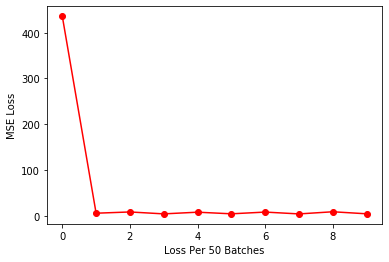

In [32]:
plt.plot(loss_history, 'ro-')
plt.xlabel('Loss Per 50 Batches')
plt.ylabel('MSE Loss')
plt.show()

In [36]:
outputs = []
net.eval()
with torch.no_grad():
    for dat in test_loader:
        x, y = dat
        out = net(x.float())
        outputs.append([x.view(-1, 96, 96), out.view(-1, 30)])

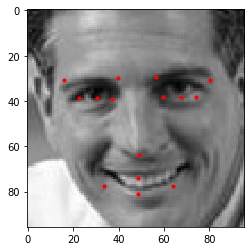

In [64]:
idx = np.random.randint(0, len(outputs), 1)[-1]
plot_predictions(outputs[idx])

In [ ]:
# both models perform equally good, but the computational expense for the Convolutional implementation is lesser
# compared to the standard model